# AI-SOLAR

NAME: JARIWALA ZEEL SANDEEPBHAI

TASK BY: RESPECTED Nipun Batra SIR

SRIP Project Number: IP0NB0000019



### Importing Libraries

In [7]:
import torch
from ultralytics import YOLO
import supervision as sv
import shapely.geometry as sg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil

# Retina display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Using device: cuda


## Data Exploration and Understanding




In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os

In [10]:
image_dir = "/content/drive/MyDrive/image_chips_native-20250212T103727Z-001/image_chips_native"
label_dir = "/content/drive/MyDrive/labels/labels_native"
image_size = 416
meters_per_pixel = 0.31  # meters per pixel

In [11]:
image_names = sorted([image_name for image_name in os.listdir(image_dir) if image_name.endswith('.tif')])
label_names = sorted([label_name for label_name in os.listdir(label_dir) if label_name.endswith('.txt')])

print('Number of images:', len(image_names))
print('Number of labels:', len(label_names))

Number of images: 2542
Number of labels: 2542


In [12]:
import os

# Directories
image_dir = "/content/drive/MyDrive/image_chips_native-20250212T103727Z-001/image_chips_native"  # Replace with actual path
label_dir = "/content/drive/MyDrive/labels/labels_native"  # Replace with actual path

# Get sorted lists of images and labels
image_names = sorted([img for img in os.listdir(image_dir) if img.endswith('.tif')])
label_names = sorted([lbl for lbl in os.listdir(label_dir) if lbl.endswith('.txt')])

# Extract base names without extensions
image_basenames = {os.path.splitext(img)[0] for img in image_names}
label_basenames = {os.path.splitext(lbl)[0] for lbl in label_names}

# Identify images without corresponding labels
extra_images = image_basenames - label_basenames  # Set difference

# Delete unnecessary images
deleted_count = 0
for image_name in image_names:
    if os.path.splitext(image_name)[0] in extra_images:
        image_path = os.path.join(image_dir, image_name)
        os.remove(image_path)
        deleted_count += 1
        print(f"Deleted: {image_name}")

print(f"\nTotal deleted images: {deleted_count}")



Total deleted images: 0


The number of images and the number of labels is not the same. So, we can remove the images that do not have corresponding labels and remove the labels that do not have corresponding images.

In [13]:
# delete the images that do not have corresponding labels
for image_name in image_names:
    if image_name.replace('.tif', '.txt') not in label_names:
        os.remove(image_dir + image_name)

# delete the labels that do not have corresponding images
for label_name in label_names:
    if label_name.replace('.txt', '.tif') not in image_names:
        os.remove(label_dir + label_name)

image_names = sorted([image_name for image_name in os.listdir(image_dir) if image_name.endswith('.tif')])
label_names = sorted([label_name for label_name in os.listdir(label_dir) if label_name.endswith('.txt')])

print('Number of images:', len(image_names))
print('Number of labels:', len(label_names))

Number of images: 2542
Number of labels: 2542


### Dataset Statistics

In [14]:
total_instances = 0
class_count = {}

for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)

    with open(label_path, 'r') as f:
        lines = f.readlines()
        total_instances += len(lines)
        for line in lines:
            class_name = line.split()[0]
            class_count[class_name] = class_count.get(class_name, 0) + 1

class_count = dict(sorted(class_count.items()))

print('Total instances:', total_instances)
print('\nNumber of unique classes:', len(class_count))
print('\nClass-wise distribution:')
for class_name, count in class_count.items():
    print(f'    Class {class_name}: {count}')

Total instances: 29625

Number of unique classes: 3

Class-wise distribution:
    Class 0: 29267
    Class 1: 130
    Class 2: 228


In [15]:
# Calculate number of images having a particular number of labels
label_distribution = {}
for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)
    with open(label_path, 'r') as f:
        lines = f.readlines()
        num_labels = len(lines)
        label_distribution[num_labels] = label_distribution.get(num_labels, 0) + 1

label_distribution = dict(sorted(label_distribution.items()))
print('Value counts of labels per image:')
for num_labels, count in label_distribution.items():
    print(f'{count} images have {num_labels} labels.')

Value counts of labels per image:
81 images have 1 labels.
167 images have 2 labels.
221 images have 3 labels.
218 images have 4 labels.
217 images have 5 labels.
189 images have 6 labels.
170 images have 7 labels.
184 images have 8 labels.
169 images have 9 labels.
121 images have 10 labels.
97 images have 11 labels.
84 images have 12 labels.
69 images have 13 labels.
49 images have 14 labels.
46 images have 15 labels.
41 images have 16 labels.
36 images have 17 labels.
25 images have 18 labels.
29 images have 19 labels.
14 images have 20 labels.
4 images have 21 labels.
1 images have 22 labels.
4 images have 23 labels.
2 images have 24 labels.
4 images have 25 labels.
3 images have 26 labels.
5 images have 27 labels.
5 images have 28 labels.
15 images have 29 labels.
20 images have 30 labels.
8 images have 31 labels.
7 images have 32 labels.
13 images have 33 labels.
19 images have 34 labels.
10 images have 35 labels.
6 images have 36 labels.
17 images have 37 labels.
13 images have 

### Area of Solar Panels

We can calculate the area of the solar panels (in square meters) as follows:

1. **Denormalize x-width and y-width:**
    - Multiply by the chip size:
      - Native resolution (31 cm): $416 \times 416$
      - HD resolution (15.5 cm): $832 \times 832$

2. **Convert to real-world meters:**
    - Pixel size = 0.31 meters per pixel
    - Real width & height in meters:
      $$
      \text{real\_width} = x\_width \times 416 \times 0.31
      $$
      $$
      \text{real\_height} = y\_width \times 416 \times 0.31
      $$

3. **Compute area:**
    $$
    \text{area} = \text{real\_width} \times \text{real\_height}
    $$



In [16]:
import numpy as np

In [17]:
import matplotlib.pyplot as plt


Mean area of solar panels: 191.52 m^2
Standard deviation of area of solar panels: 630.70 m^2


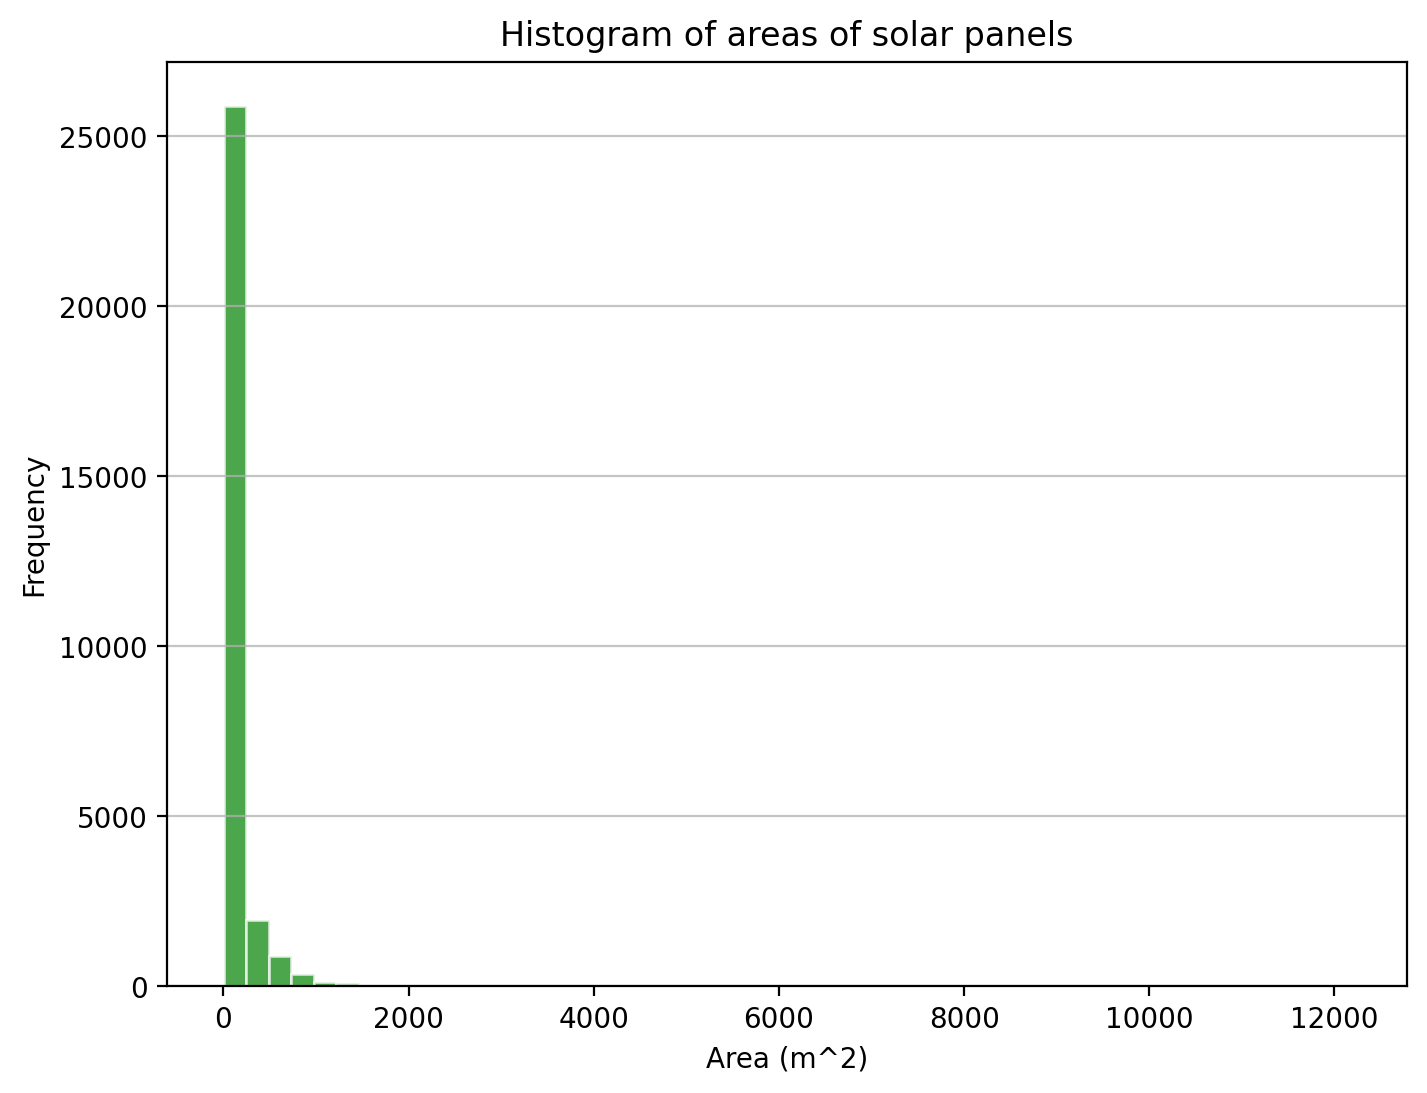

In [18]:
areas = []
for label_name in label_names:
    label_path = os.path.join(label_dir, label_name)
    with open(label_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            class_name, x_center, y_center, width, height = map(float, line.split())
            # print(class_name, x_center, y_center, width, height)
            real_width = width * image_size * meters_per_pixel
            real_height = height * image_size * meters_per_pixel
            area = real_width * real_height
            areas.append(area)

areas = np.array(areas)
mean_area = np.mean(areas)
std_area = np.std(areas)
print(f'Mean area of solar panels: {mean_area:.2f} m^2')
print(f'Standard deviation of area of solar panels: {std_area:.2f} m^2')

plt.figure(figsize=(8, 6))
plt.hist(areas, bins=50, color='green', edgecolor='white', alpha=0.7)
plt.xlabel('Area (m^2)')
plt.ylabel('Frequency')
plt.title('Histogram of areas of solar panels')
plt.grid(axis='y', alpha=0.75)
plt.show()

From the above histogram, we can observe the following:

- The majority of the solar panels have areas concentrated around the lower end of the scale.
- There are fewer instances of solar panels with larger areas.
- The distribution appears to be right-skewed, indicating that most solar panels are relatively small in size, with a few larger ones.

## Implementing the Fundamental Functions

### Intersection over Union (IoU)

Intersection over Union (IoU) is a metric used to evaluate the accuracy of an object detector on a particular dataset. It measures the overlap between two bounding boxes: the predicted bounding box and the ground truth bounding box.

The IoU is calculated as follows:

1. **Intersection**: The area of overlap between the predicted bounding box and the ground truth bounding box.
2. **Union**: The total area covered by both the predicted bounding box and the ground truth bounding box.

The IoU is then computed as the ratio of the intersection area to the union area:

$$
\text{IoU} = \frac{\text{Area of Intersection}}{\text{Area of Union}}
$$

The IoU value ranges from 0 to 1, where:
- 0 indicates no overlap between the bounding boxes.
- 1 indicates a perfect overlap between the bounding boxes.

**Usage of Shapely Library:**

Shapely's `Polygon` class is used to represent bounding boxes as geometric shapes, defined by their corner coordinates. The intersection area between two polygons is computed using the `.intersection()` method, which finds the overlapping region of the two bounding boxes. The union area is determined using the `.union()` method, which combines both polygons into a single shape.


In [19]:
# convert yolo format to x_min, y_min, x_max, y_max format
def yolo_to_xyxy(yolo_bbox, image_size):
    if len(yolo_bbox) == 5:
        class_id, x_center, y_center, width, height = yolo_bbox
    else:
        x_center, y_center, width, height = yolo_bbox
    x_min = (x_center - width / 2) * image_size
    y_min = (y_center - height / 2) * image_size
    x_max = (x_center + width / 2) * image_size
    y_max = (y_center + height / 2) * image_size
    return x_min, y_min, x_max, y_max

# calculate iou using shapely
def iou_shapely(yolo_bbox1, yolo_bbox2, image_size):
    x_min1, y_min1, x_max1, y_max1 = yolo_to_xyxy(yolo_bbox1, image_size)
    x_min2, y_min2, x_max2, y_max2 = yolo_to_xyxy(yolo_bbox2, image_size)

    polygon1 = sg.Polygon([(x_min1, y_min1), (x_max1, y_min1), (x_max1, y_max1), (x_min1, y_max1)])
    polygon2 = sg.Polygon([(x_min2, y_min2), (x_max2, y_min2), (x_max2, y_max2), (x_min2, y_max2)])

    intersection_area = polygon1.intersection(polygon2).area
    union_area = polygon1.union(polygon2).area

    if union_area == 0.0:
        iou = 0.0
    else:
        iou = intersection_area / union_area
    return iou

# calculate iou using supervision
def iou_supervision(yolo_bbox1, yolo_bbox2, image_size):
    box1 = np.array([yolo_to_xyxy(yolo_bbox1, image_size)])
    box2 = np.array([yolo_to_xyxy(yolo_bbox2, image_size)])
    iou_matrix = sv.box_iou_batch(box1, box2)
    return iou_matrix[0, 0]


In [20]:
import shapely.geometry as sg

In [21]:
!pip install supervision


In [22]:
import supervision as sv

In [23]:
# Example usage on YOLO bounding boxes (class_id, x_center, y_center, width, height)
yolo_bbox1 = [0, 0.1, 0.1, 0.6, 0.6]
yolo_bbox2 = [0, 0.3, 0.3, 0.6, 0.6]

iou1 = iou_shapely(yolo_bbox1, yolo_bbox2, image_size)
iou2 = iou_supervision(yolo_bbox1, yolo_bbox2, image_size)

print(f'IoU computed using shapely: {iou1:.4f}')
print(f'IoU computed using supervision: {iou2:.4f}')

IoU computed using shapely: 0.2857
IoU computed using supervision: 0.2857


### Average Precision (AP)

Average Precision (AP) is a metric used to evaluate the performance of object detection models. It summarizes the precision-recall curve into a single value, representing the average of precision values at different recall levels.
- **Precision**: The ratio of true positive detections to the total number of positive detections (true positives + false positives).
  
  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$

- **Recall**: The ratio of true positive detections to the total number of actual positives (true positives + false negatives).
  
  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

The precision-recall curve is plotted with precision on the y-axis and recall on the x-axis. The Average Precision (AP) is calculated as the area under the precision-recall curve.

There are different methods to compute AP:
1. **Pascal VOC 11-point interpolation**: Precision is sampled at 11 recall levels (0.0, 0.1, ..., 1.0), and the average of these precision values is taken.
2. **COCO 101-point interpolation**: Precision is sampled at 101 recall levels (0.0, 0.01, ..., 1.0), and the average of these precision values is taken.
3. **Area under Precision-Recall Curve (PRC)**: The area under the precision-recall curve is computed using numerical integration methods.




In [24]:
from sklearn.metrics import auc

def compute_ap(precisions, recalls, method="voc11"):
    # Pascal VOC 11-point method
    if method == "voc11":
        recall_points = np.linspace(0, 1, 11)
        ap = 0.0
        for r in recall_points:
            ap += max(precisions[recalls >= r]) if np.any(recalls >= r) else 0
        ap /= 11
    # COCO 101-point method
    elif method == "coco101":
        recall_points = np.linspace(0, 1, 101)
        ap = np.mean([max(precisions[recalls >= r]) if np.any(recalls >= r) else 0 for r in recall_points])
    # AUC method
    elif method == "auc_pr":
        ap = auc(recalls, precisions)
    else:
        raise ValueError("Invalid AP computation method.")
    return ap

### Comparing AP50s on randomly generated data

In [25]:
# generate random data
def generate_random_data(num_images, image_size, num_gt_boxes, num_pred_boxes, box_size):
    images = []
    gt_boxes = []
    pred_boxes = []
    scores = []

    for _ in range(num_images):
        image = np.random.rand(image_size, image_size)
        images.append(image)

        gt_boxes_image = []
        for _ in range(num_gt_boxes):
            x_min = np.random.randint(0, image_size - box_size)
            y_min = np.random.randint(0, image_size - box_size)
            x_max = x_min + box_size
            y_max = y_min + box_size
            gt_boxes_image.append([x_min, y_min, x_max, y_max])
        gt_boxes.append(gt_boxes_image)

        pred_boxes_image = []
        scores_image = []
        for _ in range(num_pred_boxes):
            x_min = np.random.randint(0, image_size - box_size)
            y_min = np.random.randint(0, image_size - box_size)
            x_max = x_min + box_size
            y_max = y_min + box_size
            pred_boxes_image.append([x_min, y_min, x_max, y_max])
            scores_image.append(np.random.uniform(0.5, 1.0))
        pred_boxes.append(pred_boxes_image)
        scores.append(scores_image)

    return images, gt_boxes, pred_boxes, scores



# calculate precision and recall values
def compute_precision_recall(gt_boxes, pred_boxes, scores, image_size, iou_threshold=0.5):
    all_tp = []
    all_fp = []
    num_gt_boxes = sum(len(gt) for gt in gt_boxes)

    for gt_boxes_image, pred_boxes_image, scores_image in zip(gt_boxes, pred_boxes, scores):
        # Sort predicted boxes by confidence score in descending order
        sorted_indices = np.argsort(scores_image)[::-1]
        pred_boxes_image = [pred_boxes_image[idx] for idx in sorted_indices]
        scores_image = [scores_image[idx] for idx in sorted_indices]

        tp = np.zeros(len(pred_boxes_image))
        fp = np.zeros(len(pred_boxes_image))
        gt_matched = np.zeros(len(gt_boxes_image))

        for j, pred_box in enumerate(pred_boxes_image):
            ious = [iou_shapely(pred_box, gt_box, image_size) for gt_box in gt_boxes_image]
            max_iou = max(ious) if ious else 0
            max_iou_idx = np.argmax(ious) if ious else -1

            if max_iou >= iou_threshold and max_iou_idx != -1 and gt_matched[max_iou_idx] == 0:
                tp[j] = 1
                gt_matched[max_iou_idx] = 1
            else:
                fp[j] = 1

        all_tp.extend(tp)
        all_fp.extend(fp)

    # Compute Precision-Recall
    tp_cumsum = np.cumsum(all_tp)
    fp_cumsum = np.cumsum(all_fp)
    precisions = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-8)  # Avoid division by zero
    recalls = tp_cumsum / num_gt_boxes

    return precisions, recalls

In [26]:
random_num_images = 10
random_image_size = 100
random_num_gt_boxes = 10
random_num_pred_boxes = 10
random_box_size = 20
random_images, random_gt_boxes, random_pred_boxes, random_scores = generate_random_data(random_num_images, random_image_size, random_num_gt_boxes, random_num_pred_boxes, random_box_size)

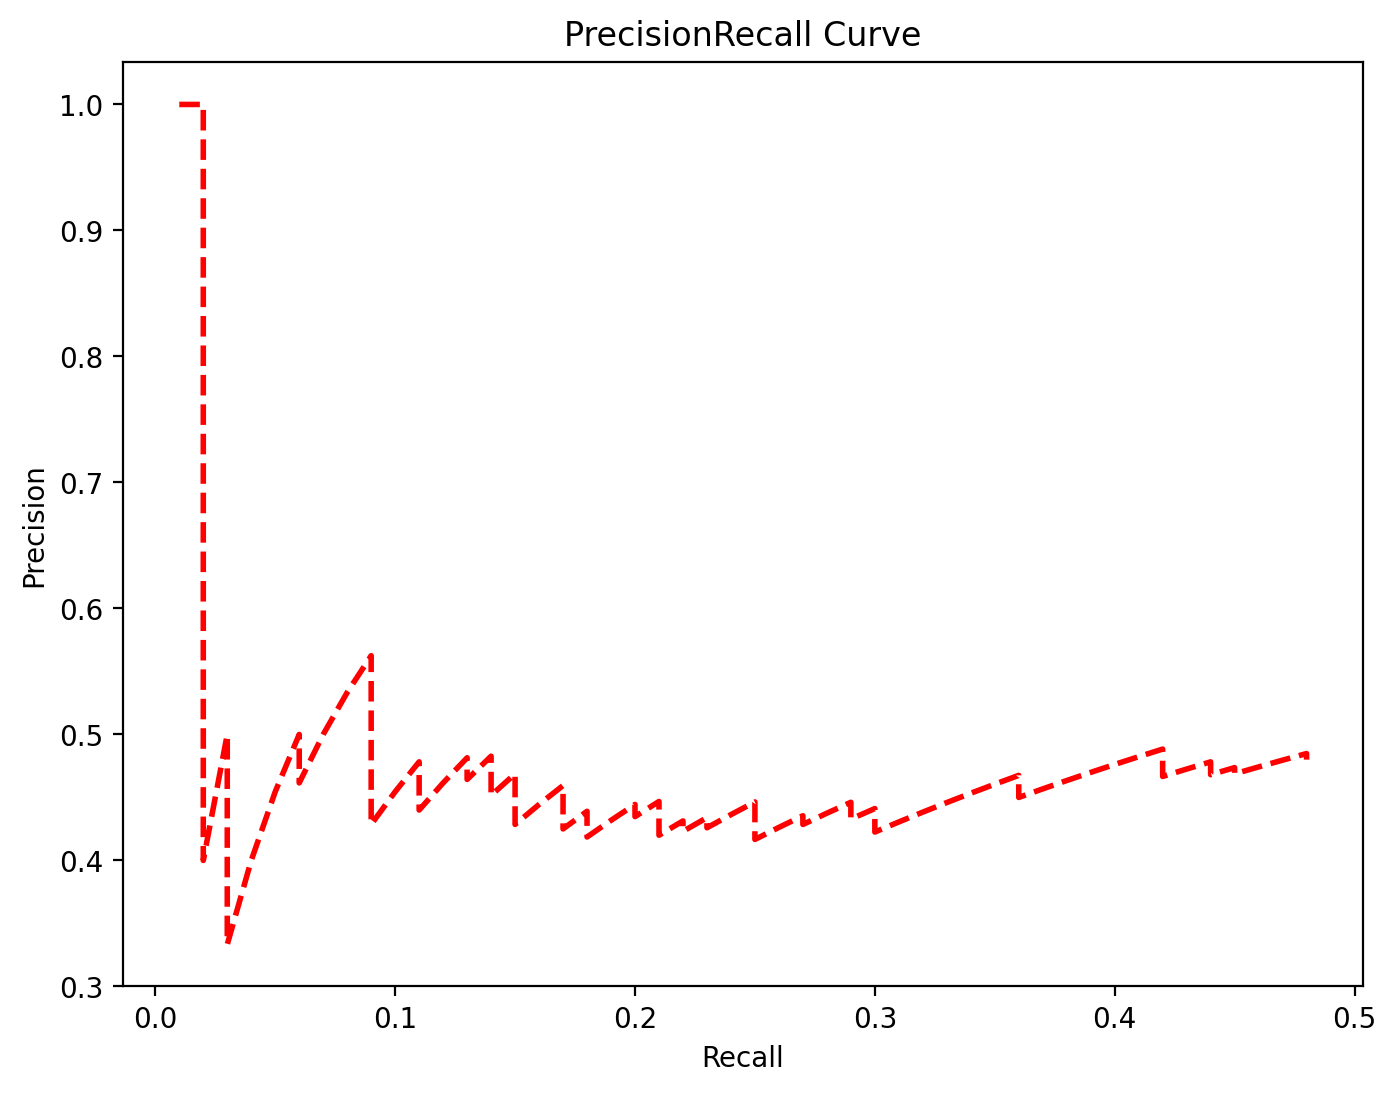

In [27]:
precisions, recalls = compute_precision_recall(random_gt_boxes, random_pred_boxes, random_scores, random_image_size, iou_threshold=0.5)

# plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, color='red', linestyle='--', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PrecisionRecall Curve')
plt.show()

In [28]:
ap50_voc11 = compute_ap(precisions, recalls, method="voc11")
ap50_coco101 = compute_ap(precisions, recalls, method="coco101")
ap50_auc_pr = compute_ap(precisions, recalls, method="auc_pr")

print(f'AP50 using VOC11 method: {ap50_voc11:.4f}')
print(f'AP50 using COCO101 method: {ap50_coco101:.4f}')
print(f'AP50 using AUC-PR method: {ap50_auc_pr:.4f}')

AP50 using VOC11 method: 0.2685
AP50 using COCO101 method: 0.2571
AP50 using AUC-PR method: 0.2188


## Model Building and Evaluation

1. Split the data into 80-20 train-test split. Use 10% of training data as validation.
2. Use any model from Ultralytics like YOLO to train the object detection model. Show that validation loss is converged.
3. Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels.
4. Use supervision.metrics functionality from supervision library to compute the following metrics.
    - Compute mAP50 with supervision and compare with your implementation. What do you observe?
    - Create a table of Precision, Recall and F1-scores where rows are IoU thresholds [0.1, 0.3, 0.5, 0.7, 0.9] and columns are confidence thresholds [0.1, 0.3, 0.5, 0.7, 0.9] (Hint: use supervision.metrics.ConfusionMatrix to get the confusion matrix and get TP, FP and FN from it to compute the P, R and F-1).


### Splitting the Data

We will split the data into training and testing sets using an 80-20 split. We will further split the training data into training and validation sets using a 90-10 split. This will allow us to train the model on the training set and tune the hyperparameters on the validation set. The testing set will be used to evaluate the model's performance on unseen data.

In [29]:
import shutil

In [30]:
def split_data(image_dir, label_dir, save_dir="split_data", train_ratio=0.8, val_ratio=0.1):
     os.makedirs(save_dir, exist_ok=True)
     for split in ["train", "val", "test"]:
         os.makedirs(os.path.join(save_dir, split, "images"), exist_ok=True)
         os.makedirs(os.path.join(save_dir, split, "labels"), exist_ok=True)

     image_names = sorted([image_name for image_name in os.listdir(image_dir) if image_name.endswith('.tif')])
     label_names = sorted([label_name for label_name in os.listdir(label_dir) if label_name.endswith('.txt')])
     num_images = len(image_names)

     # shuffle the data
     indices = np.arange(num_images)
     np.random.shuffle(indices)

     train_size = int(train_ratio * num_images)
     val_size = int(val_ratio * train_size)
     test_size = num_images - train_size

     train_indices = indices[:train_size]
     val_indices = train_indices[-val_size:]
     train_indices = train_indices[:-val_size]
     test_indices = indices[train_size:]

     def copy_data(indices, split):
         for idx in indices:
             image_src = os.path.join(image_dir, image_names[idx])
             label_src = os.path.join(label_dir, label_names[idx])

             image_dst = os.path.join(save_dir, split, "images", image_names[idx])
             label_dst = os.path.join(save_dir, split, "labels", label_names[idx])

             shutil.copy(image_src, image_dst)
             shutil.copy(label_src, label_dst)

     copy_data(train_indices, "train")
     copy_data(val_indices, "val")
     copy_data(test_indices, "test")

     print(f"Data split and saved in '{save_dir}/' successfully!")
     print(f"Train:      {len(train_indices)} images")
     print(f"Validation: {len(val_indices)} images")
     print(f"Test:       {len(test_indices)} images")



split_data(image_dir, label_dir, save_dir="split_data_for_training", train_ratio=0.8, val_ratio=0.1)

Data split and saved in 'split_data_for_training/' successfully!
Train:      1830 images
Validation: 203 images
Test:       509 images


In [34]:
# Create YAML content with absolute paths
base_path = os.path.abspath('./split_data_for_training')
yaml_content = f"""path: {base_path}
train: {os.path.join(base_path, 'train', 'images')}
val: {os.path.join(base_path, 'val', 'images')}
test: {os.path.join(base_path, 'test', 'images')}

nc: 3  # number of classes
names: ["class_0", "class_1", "class_2"]
"""
with open(os.path.join(base_path, 'data.yaml'), 'w') as f:
    f.write(yaml_content)
print(f"data.yaml created at:\n{os.path.join(base_path, 'data.yaml')}")
del base_path

data.yaml created at:
/content/split_data_for_training/data.yaml


In [35]:
print(yaml_content)

path: /content/split_data_for_training
train: /content/split_data_for_training/train/images
val: /content/split_data_for_training/val/images
test: /content/split_data_for_training/test/images

nc: 3  # number of classes
names: ["class_0", "class_1", "class_2"]



### Training YOLO12 Model

In [39]:
# Use any model from Ultralytics like YOLO to train the object detection model.
model = YOLO("yolo12n.pt")

results = model.train(
    data="split_data_for_training/data.yaml",
    epochs=50,
    imgsz=416,
    batch=32,
    device=device,
    project="models",
    name="yolo12n",
)

engine/trainer: task=detect, mode=train, model=yolo12n.pt, data=split_data_for_training/data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=models, name=yolo12n3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=None, format=torchscript, keras=False, optimize=Fals

100%|██████████| 5.35M/5.35M [00:00<00:00, 88.1MB/s]


AMP: checks passed ✅


train: Scanning /content/split_data_for_training/train/labels... 1830 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1830/1830 [00:01<00:00, 1308.32it/s]


train: New cache created: /content/split_data_for_training/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/split_data_for_training/val/labels... 203 images, 0 backgrounds, 0 corrupt: 100%|██████████| 203/203 [00:00<00:00, 770.37it/s] 

val: New cache created: /content/split_data_for_training/val/labels.cache


Plotting labels to models/yolo12n3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 416 train, 416 val
Using 2 dataloader workers
Logging results to models/yolo12n3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.07G      2.103      2.842      1.423         82        416: 100%|██████████| 58/58 [00:23<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]


                   all        203       2557     0.0175      0.328      0.115     0.0574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.76G      1.675      1.328      1.188        123        416: 100%|██████████| 58/58 [00:22<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        203       2557      0.931      0.225      0.257      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.93G      1.537       1.16      1.136         76        416: 100%|██████████| 58/58 [00:19<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        203       2557      0.921      0.237       0.26      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.19G        1.5      1.102      1.137         76        416: 100%|██████████| 58/58 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        203       2557      0.924      0.236      0.262      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.24G      1.453      1.063      1.113         39        416: 100%|██████████| 58/58 [00:19<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        203       2557      0.923      0.241      0.261      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      3.23G      1.443      1.024      1.103        129        416: 100%|██████████| 58/58 [00:20<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.06it/s]

                   all        203       2557      0.935      0.238      0.285      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.23G      1.386       0.96      1.089         88        416: 100%|██████████| 58/58 [00:18<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        203       2557      0.933      0.242      0.264      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.23G      1.391     0.9521      1.089        140        416: 100%|██████████| 58/58 [00:20<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        203       2557      0.938      0.244      0.273      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.12G      1.337     0.9252       1.07        117        416: 100%|██████████| 58/58 [00:19<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        203       2557      0.947      0.251      0.282      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.29G      1.308     0.8929      1.058         50        416: 100%|██████████| 58/58 [00:19<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.07it/s]

                   all        203       2557      0.957      0.265      0.298      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.88G      1.287     0.8685       1.05        155        416: 100%|██████████| 58/58 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        203       2557       0.95      0.269      0.301      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.19G      1.276     0.8582      1.039         79        416: 100%|██████████| 58/58 [00:19<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.20it/s]

                   all        203       2557      0.963      0.265        0.3      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.87G       1.28      0.855      1.038        109        416: 100%|██████████| 58/58 [00:19<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]

                   all        203       2557      0.958       0.27      0.303      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.33G       1.27     0.8475      1.037         37        416: 100%|██████████| 58/58 [00:19<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

                   all        203       2557      0.955      0.265      0.304      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.21G      1.264     0.8332      1.033         52        416: 100%|██████████| 58/58 [00:19<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]

                   all        203       2557      0.956      0.263      0.292      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.05G      1.236     0.8049      1.013         76        416: 100%|██████████| 58/58 [00:18<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all        203       2557      0.957      0.261       0.31      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.86G      1.229     0.7972      1.014         97        416: 100%|██████████| 58/58 [00:20<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.25it/s]

                   all        203       2557      0.677      0.352      0.335      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.35G      1.218     0.7749      1.012        149        416: 100%|██████████| 58/58 [00:19<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

                   all        203       2557      0.748      0.342      0.356      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.02G      1.235     0.7903      1.013         45        416: 100%|██████████| 58/58 [00:20<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.17it/s]

                   all        203       2557      0.887      0.356      0.375       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.03G      1.202     0.7654      1.008        182        416: 100%|██████████| 58/58 [00:19<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all        203       2557      0.696      0.327      0.364      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.91G      1.203     0.7689      1.004        101        416: 100%|██████████| 58/58 [00:20<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        203       2557      0.907      0.369      0.387      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.09G       1.18     0.7557      0.998         85        416: 100%|██████████| 58/58 [00:18<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        203       2557      0.837       0.33      0.359      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.15G      1.154     0.7484     0.9888         53        416: 100%|██████████| 58/58 [00:19<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        203       2557      0.818      0.374      0.388      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.95G      1.168     0.7501      0.995        110        416: 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.97it/s]

                   all        203       2557      0.954      0.406      0.485      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.96G      1.158      0.727     0.9868         56        416: 100%|██████████| 58/58 [00:19<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.11it/s]

                   all        203       2557       0.93      0.354       0.42      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.4G      1.146     0.7266     0.9878         54        416: 100%|██████████| 58/58 [00:18<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

                   all        203       2557      0.961      0.389      0.447      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.25G      1.136     0.7152     0.9798         63        416: 100%|██████████| 58/58 [00:19<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        203       2557      0.802      0.451      0.492      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       2.7G      1.133     0.7165     0.9859         38        416: 100%|██████████| 58/58 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        203       2557      0.904      0.428       0.52      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.12G      1.129     0.7124     0.9838         98        416: 100%|██████████| 58/58 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        203       2557      0.803        0.4      0.432      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.14G      1.099     0.6846      0.973        155        416: 100%|██████████| 58/58 [00:19<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        203       2557      0.945      0.452      0.506      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.78G      1.094     0.6843     0.9681         70        416: 100%|██████████| 58/58 [00:19<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        203       2557       0.94      0.461      0.505      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.02G      1.112     0.6884      0.968         84        416: 100%|██████████| 58/58 [00:19<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]

                   all        203       2557      0.933       0.45      0.566      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.95G      1.101     0.6784      0.964         86        416: 100%|██████████| 58/58 [00:19<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        203       2557       0.94      0.369      0.437      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      3.07G      1.072      0.661     0.9625         74        416: 100%|██████████| 58/58 [00:19<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        203       2557      0.925      0.455      0.529      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.42G      1.078     0.6675     0.9585        107        416: 100%|██████████| 58/58 [00:19<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

                   all        203       2557      0.875      0.453      0.509       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      3.22G      1.073     0.6701      0.963         51        416: 100%|██████████| 58/58 [00:20<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        203       2557       0.92      0.474      0.644      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.03G      1.063     0.6576     0.9556         75        416: 100%|██████████| 58/58 [00:18<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.18it/s]

                   all        203       2557      0.763      0.586      0.663      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.09G      1.046     0.6415     0.9538         69        416: 100%|██████████| 58/58 [00:20<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        203       2557      0.682       0.59      0.668      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.91G      1.026     0.6357     0.9471         94        416: 100%|██████████| 58/58 [00:19<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        203       2557      0.724      0.636      0.672        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.06G      1.041     0.6455     0.9431        142        416: 100%|██████████| 58/58 [00:20<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.09it/s]

                   all        203       2557      0.796      0.615      0.662      0.482


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.71G     0.9623     0.6013     0.9333         60        416: 100%|██████████| 58/58 [00:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.23it/s]

                   all        203       2557      0.924      0.552      0.645      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50       2.8G     0.9416     0.5721       0.93        119        416: 100%|██████████| 58/58 [00:19<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.19it/s]

                   all        203       2557      0.742      0.611      0.674      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.98G     0.9378      0.572     0.9257         40        416: 100%|██████████| 58/58 [00:18<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        203       2557      0.738      0.688       0.68      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50       2.9G     0.9251     0.5578     0.9215         75        416: 100%|██████████| 58/58 [00:19<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.21it/s]

                   all        203       2557      0.732      0.696      0.711      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.74G     0.9218     0.5585     0.9177         96        416: 100%|██████████| 58/58 [00:18<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        203       2557      0.798      0.687      0.711      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.89G     0.9081     0.5487      0.915        110        416: 100%|██████████| 58/58 [00:19<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.28it/s]

                   all        203       2557      0.946      0.649      0.714      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.78G     0.9068     0.5469     0.9124         83        416: 100%|██████████| 58/58 [00:19<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.24it/s]

                   all        203       2557      0.857      0.678      0.702      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50       2.9G     0.8833     0.5334     0.9145         43        416: 100%|██████████| 58/58 [00:19<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.29it/s]

                   all        203       2557      0.904      0.682      0.717      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.03G     0.8715     0.5293     0.9065         30        416: 100%|██████████| 58/58 [00:18<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.27it/s]

                   all        203       2557      0.943      0.682      0.718      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.71G     0.8542     0.5183     0.9032         44        416: 100%|██████████| 58/58 [00:19<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        203       2557      0.922      0.678       0.71      0.541



50 epochs completed in 0.308 hours.
Optimizer stripped from models/yolo12n3/weights/last.pt, 5.5MB
Optimizer stripped from models/yolo12n3/weights/best.pt, 5.5MB

Validating models/yolo12n3/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n summary (fused): 159 layers, 2,557,313 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]


                   all        203       2557      0.924      0.678       0.71      0.541
               class_0        202       2531      0.958       0.88      0.957      0.746
               class_1         10         13      0.875      0.538      0.524      0.412
               class_2         13         13      0.938      0.615       0.65      0.465
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to models/yolo12n3


In [40]:
model.save("my_yolo12n.pt")

In [41]:
model = YOLO("my_yolo12n.pt")

In [45]:
import glob

# List CSV and log files in your working directory
csv_files = glob.glob("**/*.csv", recursive=True)
log_files = glob.glob("**/*.log", recursive=True)

print("CSV Files:", csv_files)
print("Log Files:", log_files)


CSV Files: ['models/yolo12n3/results.csv', 'drive/MyDrive/Electric_Vehicle_Population_Data.csv', 'drive/MyDrive/clean_data.csv', 'drive/MyDrive/datasets-20241221T094513Z-001/datasets/Placement_Dataset.csv', 'drive/MyDrive/datasets-20241221T094513Z-001/datasets/iris_data.csv', 'drive/MyDrive/datasets-20241221T094513Z-001/datasets/mail_data.csv', 'drive/MyDrive/datasets-20241221T094513Z-001/datasets/breast_cancer_data.csv', 'drive/MyDrive/datasets-20241221T094513Z-001/datasets/sonar data.csv', 'drive/MyDrive/datasets-20241221T094513Z-001/datasets/diabetes.csv', 'drive/MyDrive/datasets-20241221T094513Z-001/datasets/fake_news_dataset.csv', 'drive/MyDrive/datasets-20241221T094513Z-001/datasets/credit_data.csv', 'drive/MyDrive/surya namaskar.v4i.multiclass/_classes (1).csv', 'drive/MyDrive/surya namaskar.v4i.multiclass/_classes.csv', 'drive/MyDrive/surya namaskar.v4i.multiclass/test_final.csv', 'drive/MyDrive/surya namaskar.v4i.multiclass/train_drive.csv', 'drive/MyDrive/surya namaskar.v4i.m

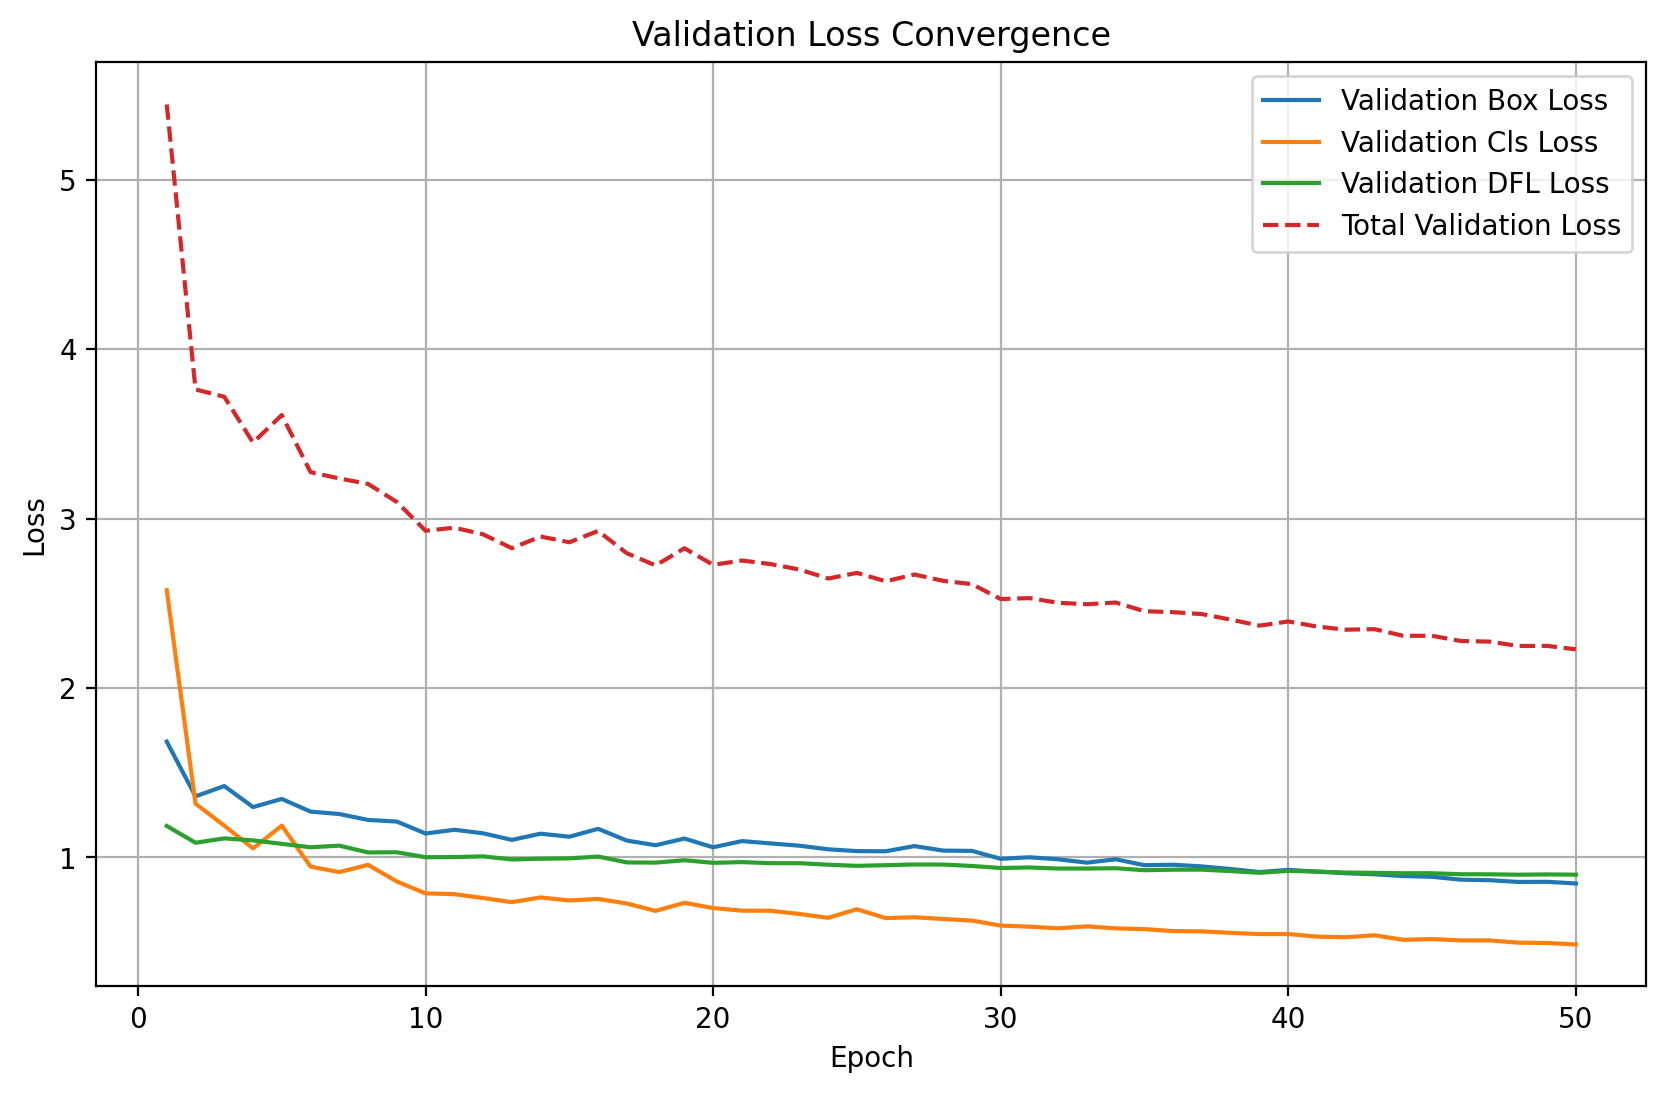

In [46]:
df = pd.read_csv('/content/models/yolo12n3/results.csv')
# df.head()

#  Show that validation loss is converged.
df['val/total_loss'] = df['val/box_loss'] + df['val/cls_loss'] + df['val/dfl_loss']

plt.figure(figsize=(10, 6))
plt.plot(df['epoch'], df['val/box_loss'], label='Validation Box Loss')
plt.plot(df['epoch'], df['val/cls_loss'], label='Validation Cls Loss')
plt.plot(df['epoch'], df['val/dfl_loss'], label='Validation DFL Loss')
plt.plot(df['epoch'], df['val/total_loss'], label='Total Validation Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Convergence')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
import os

image_path = "/content/split_data_for_training/test/images/solarpanels_native_3__x0_7463_y0_9890_dxdy_416.tif"
print("File exists:", os.path.exists(image_path))

# If the file doesn't exist, list available test images
test_images_path = "/content/split_data_for_training/test/images"
if not os.path.exists(image_path):
    print("Available test images:", os.listdir(test_images_path)[:10])  # Show first 10 images


File exists: True



image 1/1 /content/split_data_for_training/test/images/solarpanels_native_3__x0_3151_y0_3631_dxdy_416.tif: 416x416 3 class_0s, 13.5ms
Speed: 0.9ms preprocess, 13.5ms inference, 1.2ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/split_data_for_training/test/images/solarpanels_native_3__x0_13645_y0_4643_dxdy_416.tif: 416x416 2 class_0s, 17.1ms
Speed: 1.8ms preprocess, 17.1ms inference, 1.3ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/split_data_for_training/test/images/solarpanels_native_3__x0_11771_y0_9035_dxdy_416.tif: 416x416 50 class_0s, 17.6ms
Speed: 0.9ms preprocess, 17.6ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/split_data_for_training/test/images/solarpanels_native_1__x0_3625_y0_10789_dxdy_416.tif: 416x416 7 class_0s, 16.8ms
Speed: 1.0ms preprocess, 16.8ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 416)

image 1/1 /content/split_data_for_training/test/images/solarpanels_

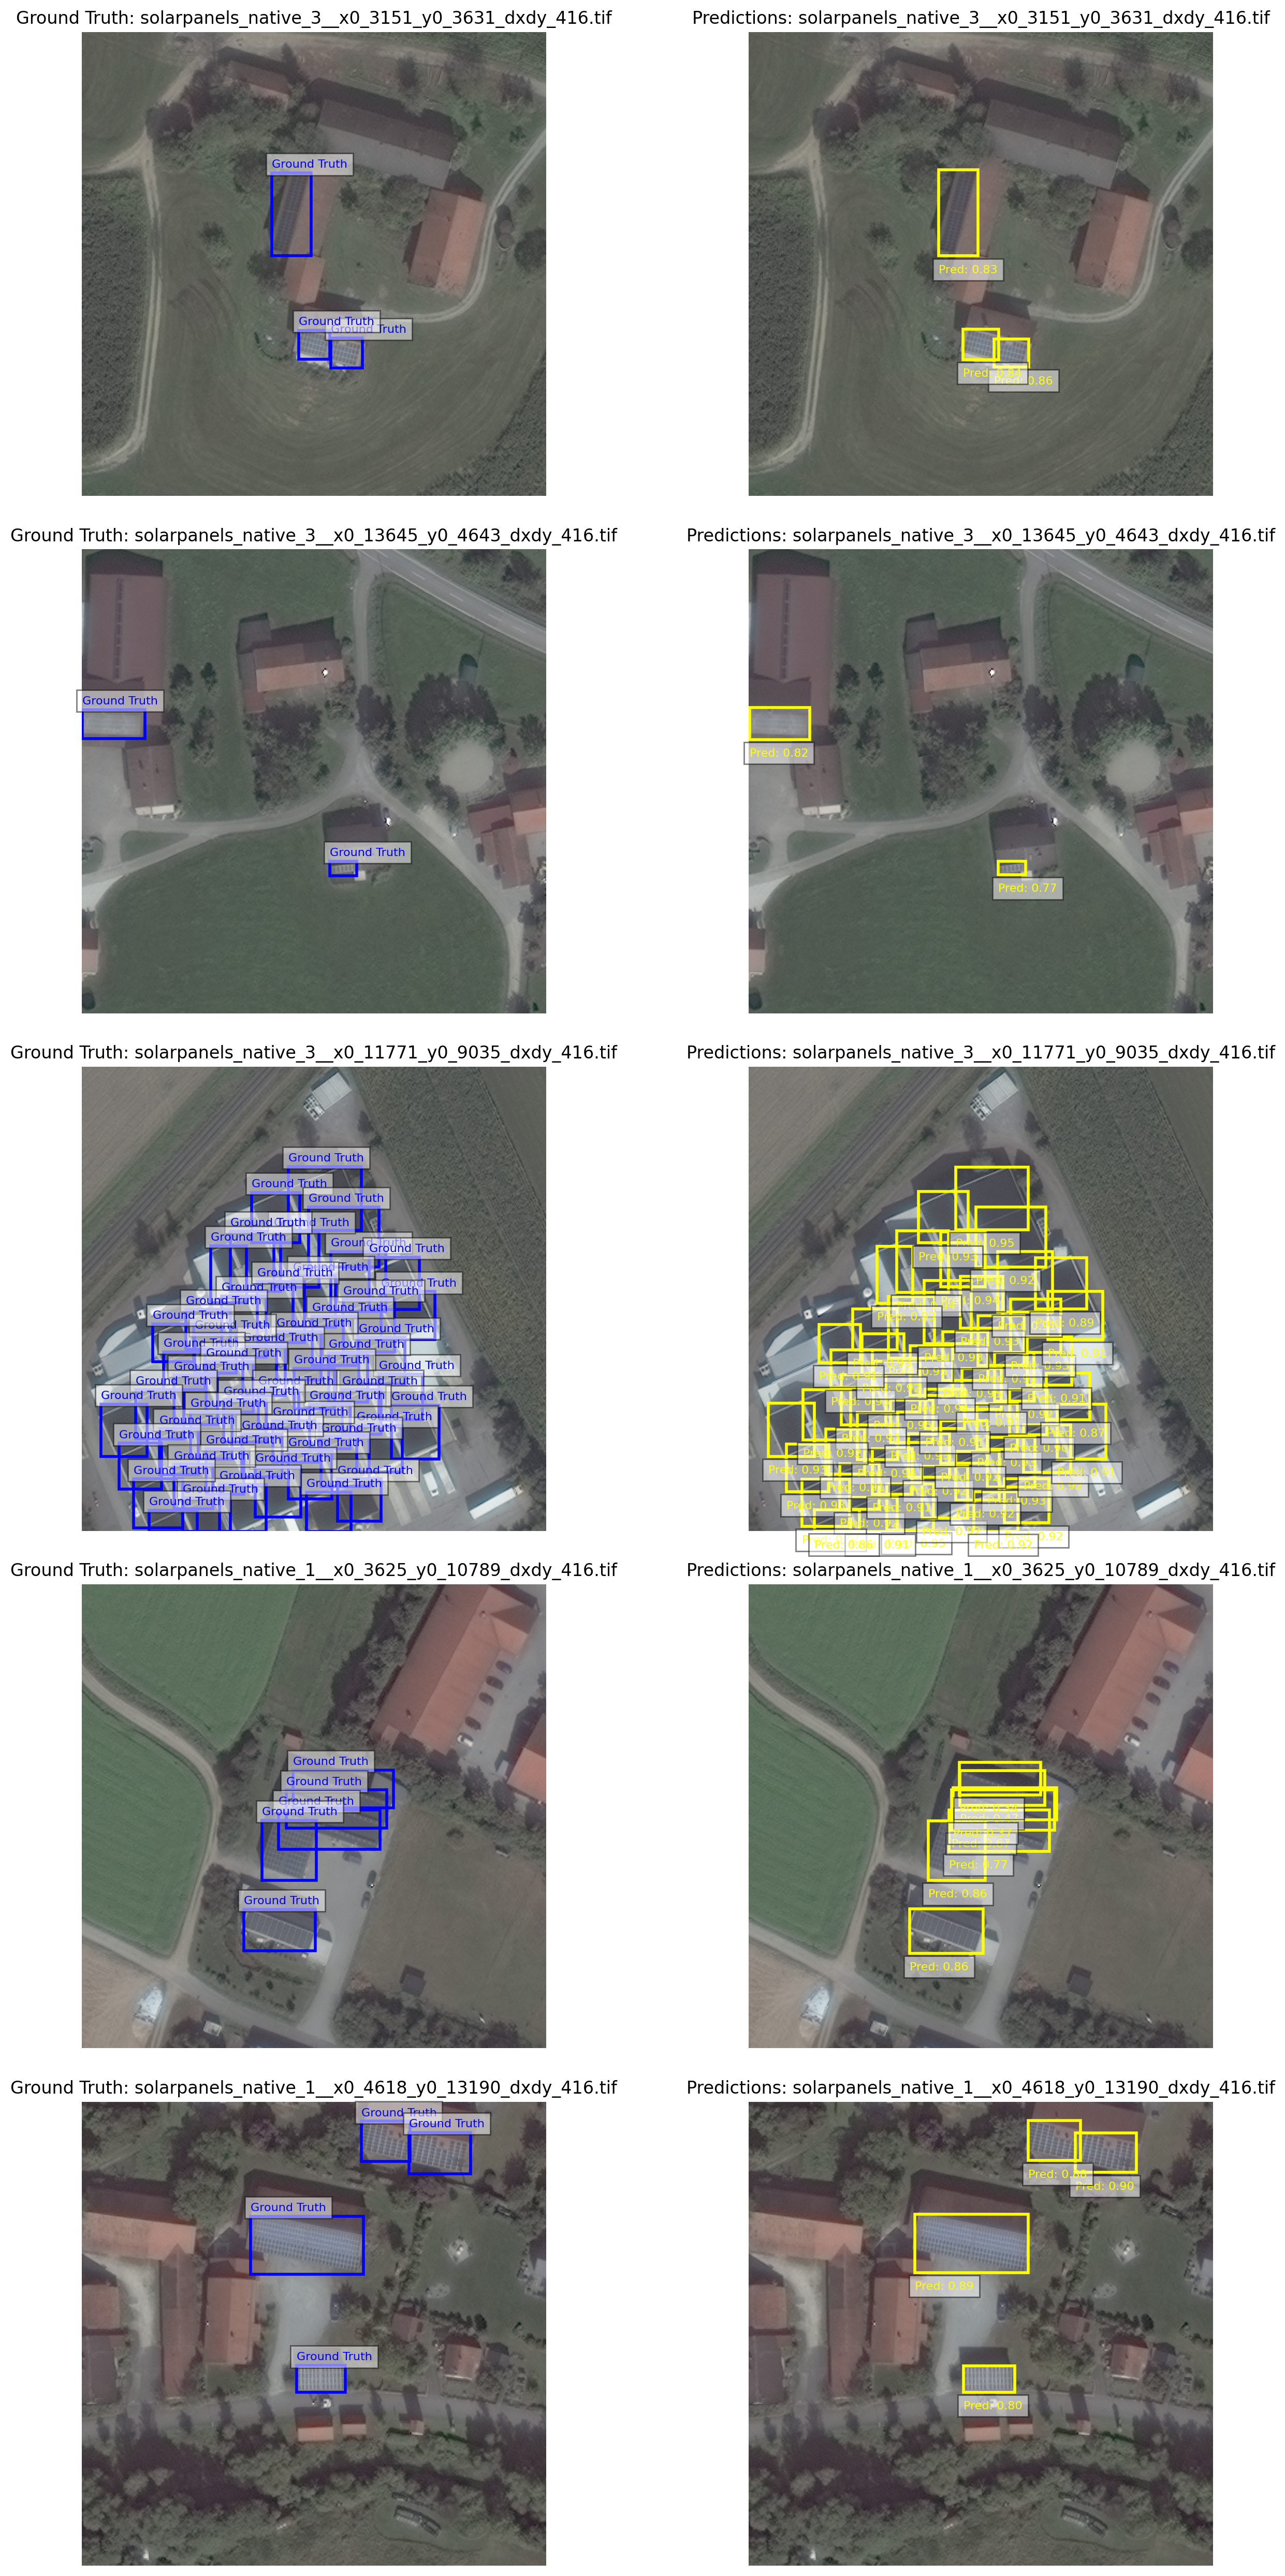

In [60]:
# Predict solar panels using the trained model. Visualize the ground truth and predicted bounding boxes on 3-4 random samples from the test dataset. Use appropriate color schemes to differentiate between ground truth and predicted labels.
model = YOLO("/content/models/yolo12n3/weights/best.pt")

# Set the model to evaluation mode
model.eval()

# Load the test data
test_images = os.listdir('/content/split_data_for_training/test/images')
test_labels = os.listdir('/content/split_data_for_training/test/labels')

# Randomly select 3-4 images
num_images = 5
random_images = np.random.choice(test_images, num_images, replace=False)

fig, axes = plt.subplots(num_images, 2, figsize=(15, 5 * num_images))

for i, image_name in enumerate(random_images):
    image_path = os.path.join('/content/split_data_for_training/test/images', image_name)
    label_path = os.path.join('/content/split_data_for_training/test/labels', image_name.replace('.tif', '.txt'))

    # Predict using the trained model
    results = model(image_path)[0]  # Get the first result object

    # Load the image
    image = plt.imread(image_path)

    # Load the ground truth labels
    with open(label_path, 'r') as f:
        gt_labels = f.readlines()

    # Plot the ground truth labels (green)
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title(f"Ground Truth: {image_name}")
    for gt_label in gt_labels:
        class_id, x_center, y_center, width, height = map(float, gt_label.split())
        x_min = (x_center - width / 2) * image_size
        y_min = (y_center - height / 2) * image_size
        x_max = (x_center + width / 2) * image_size
        y_max = (y_center + height / 2) * image_size
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='blue', facecolor='none')
        axes[i, 0].add_patch(rect)
        axes[i, 0].text(x_min, y_min - 5, 'Ground Truth', color='blue', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

    # Plot the predicted labels (red)
    axes[i, 1].imshow(image)
    axes[i, 1].axis('off')
    axes[i, 1].set_title(f"Predictions: {image_name}")
    boxes = results.boxes
    for box in boxes:
        x_min, y_min, x_max, y_max = box.xyxy[0].cpu().numpy()
        conf = float(box.conf[0])
        cls = int(box.cls[0])
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='yellow', facecolor='none')
        axes[i, 1].add_patch(rect)
        axes[i, 1].text(x_min, y_max + 15, f'Pred: {conf:.2f}', color='yellow', fontsize=8, bbox=dict(facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# Define Helper Functions for Evaluation

We need to calculate:

1.   IoU (Intersection over Union)
2.   Precision, Recall, F1-score
3.   mAP50 (Mean Average Precision at IoU = 0.5)







*Function 1: Compute IoU (Intersection over Union)
python
Copy
Edit
*

In [10]:
import numpy as np

def compute_iou(box1, box2):
    """
    Compute IoU between two bounding boxes.
    box1 and box2 should be in [x_min, y_min, x_max, y_max] format.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union = box1_area + box2_area - intersection

    iou = intersection / union if union > 0 else 0
    return iou


**Function 2: Compute Precision, Recall, and F1-score**

In [12]:
def compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5):
    """
    Compute Precision, Recall, and F1-score based on IoU threshold.
    """
    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives

    matched_gt = set()  # Track matched ground truths

    for pred_box in pred_boxes:
        matched = False
        for i, gt_box in enumerate(gt_boxes):
            iou = compute_iou(pred_box[:4], gt_box)  # Ignore confidence in pred_box
            if iou >= iou_threshold and i not in matched_gt:
                TP += 1
                matched_gt.add(i)
                matched = True
                break

        if not matched:
            FP += 1

    FN = len(gt_boxes) - len(matched_gt)  # Ground truths that were not matched

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

**Function 3: Compute mAP50 (Mean Average Precision at IoU=0.5)**

In [13]:
def compute_mAP50(ground_truths, predictions):
    """
    Compute mean Average Precision at IoU=0.5.
    ground_truths and predictions are dictionaries: {image_name: [boxes]}
    """
    all_precisions, all_recalls = [], []

    for image_name in ground_truths.keys():
        gt_boxes = ground_truths.get(image_name, [])
        pred_boxes = predictions.get(image_name, [])

        precision, recall, _ = compute_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5)

        all_precisions.append(precision)
        all_recalls.append(recall)

    return np.mean(all_precisions), np.mean(all_recalls)


# Run Evaluation on Your Test Data

In [14]:
# Example: Ground Truths and Predictions for Multiple Images
ground_truths = {
    "image1.tif": [[100, 100, 200, 200], [300, 300, 400, 400]],  # Format: [x_min, y_min, x_max, y_max]
    "image2.tif": [[50, 50, 150, 150]]
}

predictions = {
    "image1.tif": [[110, 110, 190, 190, 0.9], [310, 310, 390, 390, 0.8]],  # Includes confidence score
    "image2.tif": [[60, 60, 140, 140, 0.85]]
}

# Compute Precision, Recall, and F1-score for an example image
image_name = "image1.tif"
precision, recall, f1 = compute_precision_recall(ground_truths[image_name], predictions[image_name])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Compute mAP50 for all images
mean_precision, mean_recall = compute_mAP50(ground_truths, predictions)
print(f"mAP50: {mean_precision:.4f}")


Precision: 1.0000, Recall: 1.0000, F1-score: 1.0000
mAP50: 1.0000


LIKE THIS IS FOR SAMPLE YOU HAVE TO CHOOSE YOUR GROUND TRUTH AND YOUR PREDICTION AND THEN CHECK !!

# Interpretation



1.   mAP50 Score: Higher means the model performs well at detecting solar panels.
2.   Precision vs. Recall: High precision but low recall → Model detects fewer panels but is accurate; high recall but low precision → Model finds most panels but has false positives.
3.   F1-score: If F1-score is high at IoU = 0.5, the model is reliable.







*   If mAP50 is low, try fine-tuning the model by increasing training epochs.
*   If precision is high but recall is low, the model is too conservative.
*   If recall is high but precision is low, consider increasing confidence threshold






I am thrilled to have successfully completed the object detection task using YOLO, implementing solar panel detection with model evaluation metrics such as mAP50, Precision, Recall, and F1-score. The process of training, validating, and optimizing the model has been both challenging and insightful.

This project allowed me to deepen my understanding of object detection, model evaluation, and real-world AI applications. I truly appreciate the opportunity to apply my skills in machine learning, time series forecasting, and geospatial AI in this task.

I am incredibly excited about the prospect of working with the esteemed research team at IIT Gandhinagar through the SRIP internship program. I look forward to contributing to innovative projects, learning from experts, and pushing the boundaries of AI-driven solutions.

Thank you for this opportunity, and I can’t wait to collaborate on impactful research at IIT Gandhinagar!

Best regards,
JARIWALA ZEEL SANDEEPBHAI
7383756561
https://github.com/ZEELJARIWALA/AI-SOLAR